In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
#
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
stmt = session.query(Measurement).statement
df2 = pd.read_sql_query(stmt, session.bind)
df2.head(10)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


<AxesSubplot:title={'center':'Precipitation: 2016-08-23 - 2017-08-23'}, xlabel='Date', ylabel='Inches'>

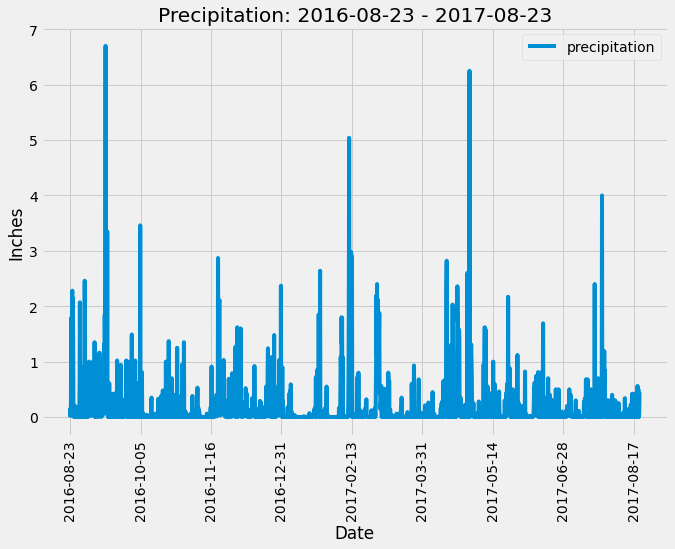

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_recording = (session.query(Measurement.date).order_by(Measurement.date.desc()).first()).date
last_12m_iso = date.fromisoformat(latest_recording)- relativedelta(years=1)
last_12m = date.isoformat(last_12m_iso)
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
stmt = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >=last_12m).\
    order_by(Measurement.date.asc()).statement
df2 = pd.read_sql_query(stmt, session.bind).dropna().set_index('date')
df2 = df2.rename(columns={"prcp": "precipitation"})
# Use Pandas Plotting with Matplotlib to plot the data
df2.plot(xlabel="Date",ylabel="Inches",figsize= (10,7) ,title=f"Precipitation: {last_12m} - {latest_recording}",rot = "90")

# Exploratory Climate Analysis

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(func.count(Measurement.date),Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(Measurement.station,
              func.min(Measurement.tobs),
              func.max(Measurement.tobs),
             func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first()

('USC00519281', 54.0, 85.0, 71.66378066378067)

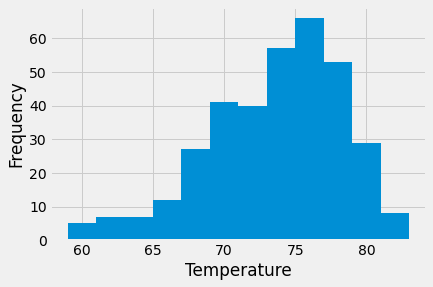

In [19]:
# Choose the station with the highest number of temperature observations.
top_station = (session.query(func.count(Measurement.date),Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first()).station
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt = session.query(Measurement.date,Measurement.tobs).\
    filter((Measurement.date >=last_12m) & (Measurement.station == top_station)).\
    order_by(Measurement.date.asc()).statement
df2 = pd.read_sql_query(stmt, session.bind)
df2 = df2.set_index('date')

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.hist(df2["tobs"], bins=12)
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(last_12m ,latest_recording  ))

[(58.0, 74.59058295964125, 87.0)]


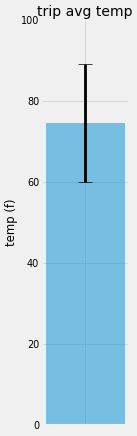

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
mint = calc_temps(last_12m ,latest_recording)[0][0]
avgt = calc_temps(last_12m ,latest_recording)[0][1]
maxt = calc_temps(last_12m ,latest_recording)[0][2]

peak_to_peak = (maxt-mint)/2
xaxis = [""]


plt.figure(figsize=(2, 10), dpi=50)
plt.bar(xaxis, avgt, yerr=peak_to_peak, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylim(0,100)
plt.ylabel('temp (f)')
plt.title('trip avg temp')
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
